<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/06-Evaluate_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables


In [ ]:
# !pip install -q llama-index==0.14.0 openai==1.107.0 chromadb==1.0.21 llama-index-vector-stores-chroma==0.5.2 \
#                 llama-index-llms-google-genai==0.3.0 jedi==0.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/67.3 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.0/951.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.4 MB/s eta 0:00:00
  

In [2]:
import os

# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"
# os.environ["GOOGLE_API_KEY"] = "<YOUR_API_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] = userdata.get('Google_api_key')

from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

True

In [3]:
# Allows running asyncio in environments with an existing event loop, like Jupyter notebooks.

import nest_asyncio

nest_asyncio.apply()

In [4]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.embed_model = OpenAIEmbedding(
    model="text-embedding-3-small"
)

[nltk_data] Downloading package punkt_tab to c:\DROPBOX\Документы\Карз
[nltk_data]     ановы\Андрей\__CHALLENGES\AI_Full_Stack_Developer\.ven
[nltk_data]     v\Lib\site-
[nltk_data]     packages\llama_index\core\_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Create a VectoreStore


In [5]:
# import chromadb

# # create client and a new collection
# # chromadb.EphemeralClient saves data in-memory.
# chroma_client = chromadb.PersistentClient(path="./mini-llama-articles")
# chroma_collection = chroma_client.create_collection("mini-llama-articles")

from qdrant_client import QdrantClient, models as qdrant_models

from llama_index.vector_stores.qdrant import QdrantVectorStore

In [10]:
# from llama_index.vector_stores.chroma import ChromaVectorStore

# Define a storage context object using the created vector database.
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

qdrant_client = QdrantClient(url=f"http://{os.getenv("qdrant_server_id")}:6333")

collection_name = "mini-llama-articles_06"

if qdrant_client.collection_exists(collection_name=collection_name):
    collection = qdrant_client.get_collection(collection_name=collection_name)
else:
    collection = qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=qdrant_models.VectorParams(
            size=1536,  # dimension of the embedding model
            distance=qdrant_models.Distance.COSINE
        )
    )

In [15]:
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name
)

# Load the Dataset (CSV)


## Download


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model.


In [ ]:
# !curl -o ./mini-dataset.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   457k      0 --:--:-- --:--:-- --:--:--  458k


## Load the Articles


In [9]:
import csv

rows = []

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
            # Skip header row
        rows.append(row)

# The number of characters in the dataset.
len(rows)

14

# Convert to Document obj


In [12]:
from llama_index.core import Document
from llama_index.core.schema import TextNode

# Convert the chunks to Document objects so the LlamaIndex framework can process them.
documents = [
    Document(
        text=row[1],
        metadata={"title": row[0], "url": row[2], "source_name": row[3]},
    )
    for row in rows
]
# By default, the node/chunks ids are set to random uuids. To ensure same id's per run, we manually set them.
for idx, doc in enumerate(documents):
    doc.id_ = f"doc_{idx}"

In [13]:
documents[0]

Document(id_='doc_0', embedding=None, metadata={'title': "Beyond GPT-4: What's New?", 'url': 'https://pub.towardsai.net/beyond-gpt-4-whats-new-cbd61a448eb9#dda8', 'source_name': 'towards_ai'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='LLM Variants and Meta\'s Open Source Before shedding light on four major trends, I\'d share the latest Meta\'s Llama 2 and Code Llama. Meta\'s Llama 2 represents a sophisticated evolution in LLMs. This suite spans models pretrained and fine-tuned across a parameter spectrum of 7 billion to 70 billion. A specialized derivative, Llama 2-Chat, has been engineered explicitly for dialogue-centric applications. Benchmarking revealed Llama 2\'s superior performance over most extant open-source chat models. Human-centric evaluations, focusing on safety and utility metrics, positioned Llama 2-Chat as a potential contender against proprietary, closed-source counterparts. The development trajectory of Llama 2 emphasized 

# Transforming


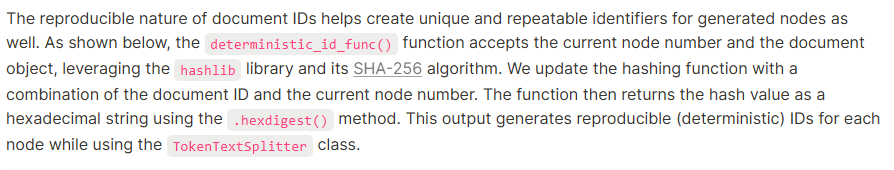

In [19]:
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.schema import BaseNode

import hashlib

# def deterministic_id_func(i: int, doc: BaseNode) -> str:
#     """Deterministic ID function for the text splitter.
#     This will be used to generate a unique repeatable identifier for each node."""
    # unique_identifier = doc.id_ + str(i)
    # hasher = hashlib.sha256()
    # hasher.update(unique_identifier.encode("utf-8"))
    # return hasher.hexdigest()

import uuid
# import hashlib
from typing import Any

QDRANT_NS = uuid.UUID(
    "00000000-0000-0000-0000-0000000000aa"
)  # keep constant across runs


def deterministic_id_func(i: int, document: Any) -> str:
    """
    LlamaIndex splitter passes (i, document).
    - i: zero-based chunk index
    - document: llama_index.core.schema.Document
    Returns a deterministic UUID string (Qdrant-compatible).
    """
    # Prefer the document's stable ID; fall back to a hash of its text
    doc_id = getattr(document, "id_", None)
    if not doc_id:
        text = getattr(document, "text", "") or ""
        # stable doc fingerprint if no id_
        doc_id = hashlib.sha256(text.encode("utf-8")).hexdigest()[:16]

    key = f"{doc_id}:{i}"  # unique per chunk of this document
    return str(uuid.uuid5(QDRANT_NS, key))


text_splitter = TokenTextSplitter(
    separator=" ", chunk_size=512, chunk_overlap=128, id_func=deterministic_id_func
)

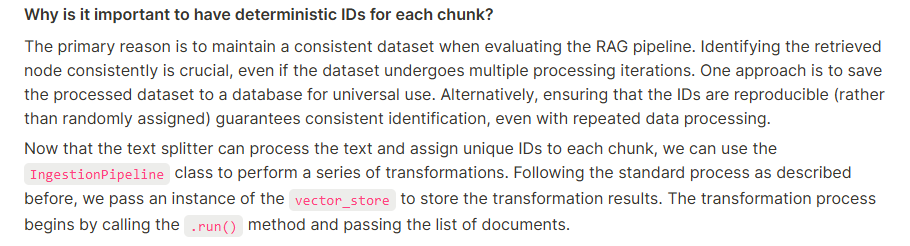

In [20]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.ingestion import IngestionPipeline

pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        OpenAIEmbedding(model = 'text-embedding-3-small'),
    ],
    vector_store=vector_store,
)

nodes = pipeline.run(documents=documents, show_progress=True)

Parsing nodes:   0%|          | 0/14 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/108 [00:00<?, ?it/s]

In [21]:
nodes[0]

TextNode(id_='b4341f7b-f1af-568c-a86e-901bb6a421bf', embedding=[0.004633472301065922, 0.016692597419023514, 0.06155563145875931, -0.016222193837165833, 0.020455822348594666, -0.0224449560046196, 0.00625972356647253, 0.014663142152130604, -0.00014427100541070104, 0.005826280917972326, 0.02755219303071499, -0.045642558485269547, -0.03534744679927826, 0.004250429570674896, -0.035132404416799545, -0.02787475474178791, -0.034218478947877884, -0.04634144529700279, -0.015294826589524746, 0.03763226419687271, 0.013137691654264927, 0.0072442106902599335, -0.034541040658950806, 0.025952821597456932, -0.005110595840960741, -0.026893628761172295, -0.0479004941880703, 0.01755276322364807, -0.01737804152071476, -0.02486417442560196, 0.05268516764044762, -0.025348016992211342, -0.02216271497309208, -0.01169288158416748, -0.024837292730808258, 0.018386049196124077, -0.005261796526610851, -0.010080070234835148, 0.020294541493058205, -0.004458751063793898, -0.032283104956150055, -0.06263083964586258, -0

# Load Indexes


In [40]:
# Create your index
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_vector_store(vector_store)

In [41]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.

# from llama_index.llms.google_genai import GoogleGenAI
# import google.genai.types as types

# config = types.GenerateContentConfig(
#     thinking_config=types.ThinkingConfig(thinking_budget=0),
#     max_output_tokens=512,
#     temperature=1,
# )

# llm = GoogleGenAI(model="gemini-2.5-flash",generation_config=config)

from llama_index.llms.openrouter import OpenRouter

# !pip install llama-index-llms-openrouter
llm_openrouter = OpenRouter(
    model="google/gemini-2.5-flash",
    max_tokens=512,
    temperature=1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
)


query_engine = index.as_query_engine(llm=llm_openrouter, similarity_top_k=5)

In [42]:
res = query_engine.query("How many parameters LLaMA 2 model has?")

In [43]:
res.response

'The Llama 2 model is available in multiple sizes with varying numbers of parameters: 7 billion, 13 billion, 34 billion, and 70 billion. While the 7B, 13B, and 70B parameter models have been released, the 34B model is still anticipated.'

In [26]:
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 ead282c5-92b4-521e-9796-3f850c3748da
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the technique of their adjustment "adapter-tuning", we add these layers to the pre-trained base model and only

# Evaluate the retrieval process and quality of answers

We can evaluate our RAG system with a dataset of questions and associated chunks. Given a question, we can see if the RAG system retrieves the correct chunks of text that can answer the question.

You can generate a synthetic dataset with an LLM such as `gemini-2.5-flash` or create an authentic and manually curated dataset.

Note that a **well curated dataset will always be a better option**, especially for a specific domain or use case.


In our example, we will generate a synthetic dataset using `gemini-2.5-flash` to make it simple.

This is the default prompt that the `generate_question_context_pairs` function will uses:

```python
DEFAULT_QA_GENERATE_PROMPT_TMPL = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and no prior knowledge,
generate only questions based on the below query.

You are a Teacher/Professor. Your task is to setup \
{num_questions_per_chunk} questions for an upcoming \
quiz/examination. The questions should be diverse in nature \
across the document. Restrict the questions to the \
context information provided."
"""
```


In [28]:
# Free Tier-Gemini API key
from llama_index.core.llms.utils import LLM
from llama_index.core.schema import MetadataMode, TextNode
from tqdm import tqdm
import json
import re
import uuid
import warnings
import time
from typing import Dict, List, Tuple
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

DEFAULT_QA_GENERATE_PROMPT_TMPL = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and not prior knowledge.
generate only questions based on the below query.

You are a Teacher/ Professor. Your task is to setup \
{num_questions_per_chunk} questions for an upcoming \
quiz/examination. The questions should be diverse in nature \
across the document. Restrict the questions to the \
context information provided."
"""

def generate_question_context_pairs(
    nodes: List[TextNode],
    llm: LLM,
    qa_generate_prompt_tmpl: str = DEFAULT_QA_GENERATE_PROMPT_TMPL,
    num_questions_per_chunk: int = 2,
    request_delay: float = 2.0 # seconds between requests to avoid rate limiting
) -> EmbeddingQAFinetuneDataset:
    """Generate examples given a set of nodes with delays between requests."""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }

    queries = {}
    relevant_docs = {}

    for node_id, text in tqdm(node_dict.items()):
        query = qa_generate_prompt_tmpl.format(
            context_str=text, num_questions_per_chunk=num_questions_per_chunk
        )
        response = llm.complete(query)

        result = str(response).strip().split("\n")
        questions = [
            re.sub(r"^\d+[\).\s]", "", question).strip() for question in result
        ]
        questions = [question for question in questions if len(question) > 0][
            :num_questions_per_chunk
        ]

        num_questions_generated = len(questions)
        if num_questions_generated < num_questions_per_chunk:
            warnings.warn(
                f"Fewer questions generated ({num_questions_generated}) "
                f"than requested ({num_questions_per_chunk})."
            )

        for question in questions:
            question_id = str(uuid.uuid4())
            queries[question_id] = question
            relevant_docs[question_id] = [node_id]

        time.sleep(request_delay)

    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

#from llama_index.core.evaluation import generate_question_context_pairs

In [30]:
len(nodes)

108

In [31]:
nodes[0]

TextNode(id_='b4341f7b-f1af-568c-a86e-901bb6a421bf', embedding=[0.004633472301065922, 0.016692597419023514, 0.06155563145875931, -0.016222193837165833, 0.020455822348594666, -0.0224449560046196, 0.00625972356647253, 0.014663142152130604, -0.00014427100541070104, 0.005826280917972326, 0.02755219303071499, -0.045642558485269547, -0.03534744679927826, 0.004250429570674896, -0.035132404416799545, -0.02787475474178791, -0.034218478947877884, -0.04634144529700279, -0.015294826589524746, 0.03763226419687271, 0.013137691654264927, 0.0072442106902599335, -0.034541040658950806, 0.025952821597456932, -0.005110595840960741, -0.026893628761172295, -0.0479004941880703, 0.01755276322364807, -0.01737804152071476, -0.02486417442560196, 0.05268516764044762, -0.025348016992211342, -0.02216271497309208, -0.01169288158416748, -0.024837292730808258, 0.018386049196124077, -0.005261796526610851, -0.010080070234835148, 0.020294541493058205, -0.004458751063793898, -0.032283104956150055, -0.06263083964586258, -0

In [29]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.

# from llama_index.llms.google_genai import GoogleGenAI

# llm = GoogleGenAI(model="gemini-2.5-flash", temperature=0.3)

from llama_index.llms.openrouter import OpenRouter

llm = OpenRouter(
    model="google/gemini-2.5-flash",
    max_tokens=512,
    temperature=0.3,
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

rag_eval_dataset = generate_question_context_pairs(
    nodes[:25],
    llm=llm,
    num_questions_per_chunk=1,
    request_delay=4
)

100%|██████████| 25/25 [02:18<00:00,  5.55s/it]


In [32]:

# Save the dataset as a json file for later use
rag_eval_dataset.save_json("./06_rag_eval_dataset.json")


In [ ]:
# next(iter(rag_eval_dataset))

('queries',
 {'4a48cbd4-f29f-41ac-992d-afb709dcecb0': "Describe the different variants of Meta's Llama 2 and Code Llama models, highlighting their specific applications and how they compare to other LLMs mentioned in the text.",
  '74aedccc-6443-459e-b642-9c8e73483421': 'How do multimodal AI models like GPT-4 differ from earlier LLMs such as ChatGPT (GPT-3.5), and what new capabilities do they introduce to AI systems?',
  '87280404-e402-4132-98b0-8c4a4169ecc0': 'How do Vector DBs, such as Weaviate and Milvus, differ from traditional databases in their data storage and retrieval mechanisms, and what specific AI tasks are they ideally suited for?',
  'b6e52c30-8a23-452f-bf36-2e70971a105f': 'Explain the concept of "LLM as an OS" and how it differs from traditional AI applications, providing examples of its potential impact on digital interactions.',
  '1dd1c5d8-5011-4f8f-aedf-08b89ac65544': 'How has the role of LLMs evolved from being a service to becoming a platform, and what does this s

In [ ]:
# #Paid-Gemini API Key

# from llama_index.core.evaluation import generate_question_context_pairs

# #Define a query engine that is responsible for retrieving related pieces of text,
# #and using a LLM to formulate the final answer.

# from llama_index.llms.google_genai import GoogleGenAI

# import google.genai.types as types

# config = types.GenerateContentConfig(
#     thinking_config=types.ThinkingConfig(thinking_budget=0),
#     max_output_tokens=512,
#     temperature=0.3,
# )

# llm = GoogleGenAI(model="gemini-2.5-flash", generation_config=config)

# rag_eval_dataset = generate_question_context_pairs(nodes, llm=llm, num_questions_per_chunk=1)

# # We can save the dataset as a json file for later use.
# rag_eval_dataset.save_json("./rag_eval_dataset.json")

In [36]:
# We can also load the dataset from a previously saved json file.
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

rag_eval_dataset_loaded = EmbeddingQAFinetuneDataset.from_json("./06_rag_eval_dataset.json")

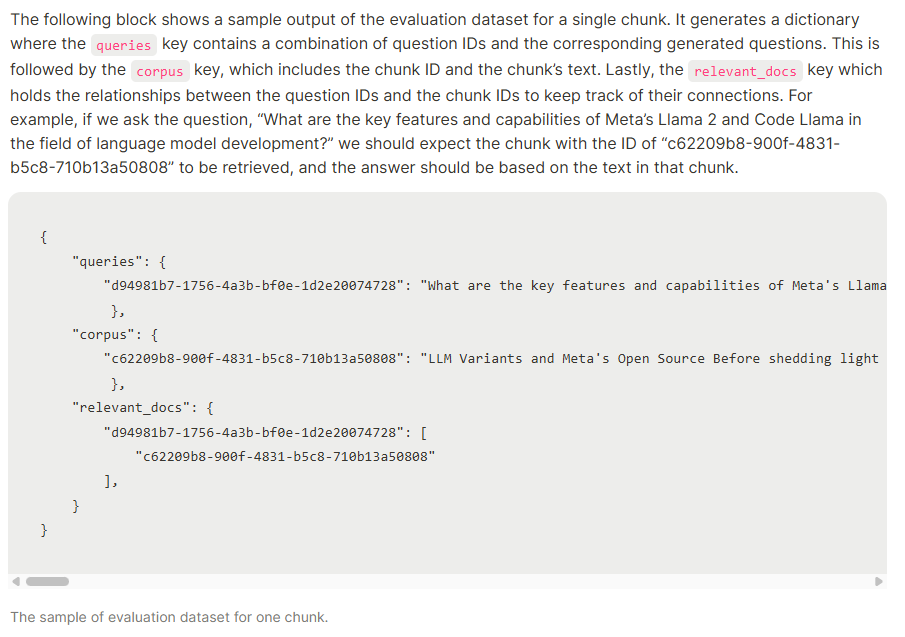

### Evaluation for Hit Rate and Mean Reciprocal Rank (MRR)

We will make use of `RetrieverEvaluator` available in Llama-index. We will measure the Hit Rate and Mean Reciprocal Rank (MRR).

**Hit Rate:**

Think of the Hit Rate like playing a game of guessing. You're given a question and you need to guess the correct answer from a list of options. The Hit Rate measures how often you guess the correct answer by only looking at your top few guesses. If you often find the right answer in your first few guesses, you have a high Hit Rate. So, in the context of a retrieval system, it's about how frequently the system finds the correct document within its top 'k' picks (where 'k' is a number you decide, like top 5 or top 10).

**Mean Reciprocal Rank (MRR):**

MRR is a bit like measuring how quickly you can find a treasure in a list of boxes. Imagine you have a row of boxes and only one of them has a treasure. The MRR calculates how close to the start of the row the treasure box is, on average. If the treasure is always in the first box you open, you're doing great and have an MRR of 1. If it's in the second box, the score is 1/2, since you took two tries to find it. If it's in the third box, your score is 1/3, and so on. MRR averages these scores across all your searches. So, for a retrieval system, MRR looks at where the correct document ranks in the system's guesses. If it's usually near the top, the MRR will be high, indicating good performance.
In summary, Hit Rate tells you how often the system gets it right in its top guesses, and MRR tells you how close to the top the right answer usually is. Both metrics are useful for evaluating the effectiveness of a retrieval system, like how well a search engine or a recommendation system works.


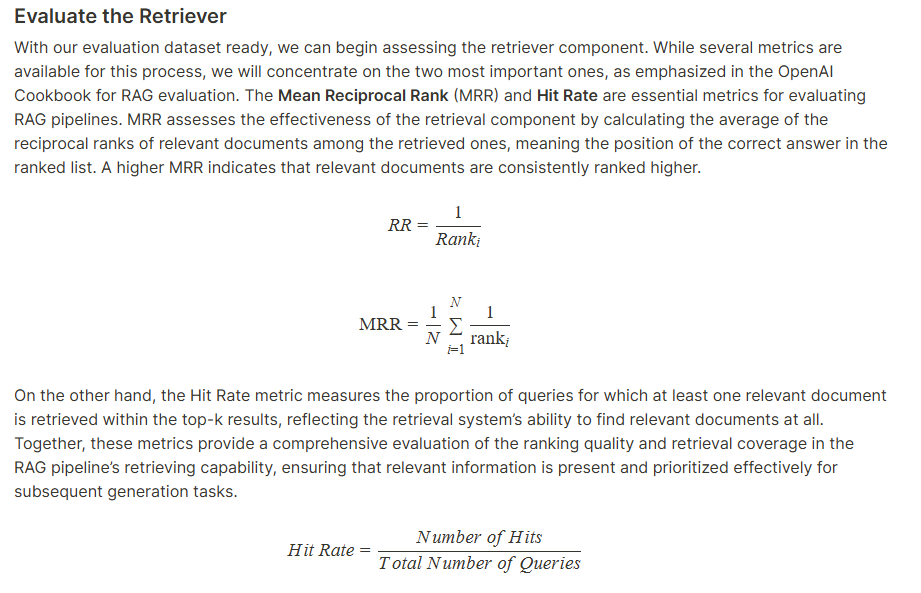

In [37]:
import pandas as pd

def display_results_retriever(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"Retriever Name": [name], "Hit Rate": [hit_rate], "MRR": [mrr]}
    )

    return metric_df

In [ ]:
# Metrics from metrics.py

# METRIC_REGISTRY: Dict[str, Type[BaseRetrievalMetric]] = {
#     "hit_rate": HitRate,
#     "mrr": MRR,
#     "precision": Precision,
#     "recall": Recall,
#     "ap": AveragePrecision,
#     "ndcg": NDCG,
#     "cohere_rerank_relevancy": CohereRerankRelevancyMetric,
# }

In [44]:
retriever = index.as_retriever(similarity_top_k=2)


In [ ]:
retriever.retrieve("How many parameters LLaMA 2 model has?").

<BoundFunctionWrapper at 0x000001B5C75483C0 for method at 0x000001B5C65A1740>

Summary

You’re using an async evaluator/retriever, but your QdrantVectorStore lacks an async client (aclient). Either run the sync evaluator, or pass AsyncQdrantClient via aclient so aretrieve/aquery can call aclient.search successfully.

In [46]:
from qdrant_client import QdrantClient, AsyncQdrantClient
from llama_index.vector_stores.qdrant import QdrantVectorStore



client = QdrantClient(url=f"http://{os.getenv("qdrant_server_id")}:6333")
aclient = AsyncQdrantClient(url=f"http://{os.getenv('qdrant_server_id')}:6333")

In [49]:
# Qdrant Vector Store that allows both sync and ASYNC QUERIES
vector_store = QdrantVectorStore(
    client=client,
    aclient=aclient,  # important for async queries
    collection_name="mini-llama-articles_06",
)


In [50]:
# Create your index
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_vector_store(vector_store)


In [51]:
from llama_index.core.evaluation import RetrieverEvaluator

# We can evaluate the retievers with different top_k values.
for i in [2, 4, 6, 8, 10]:
    retriever = index.as_retriever(similarity_top_k=i)
    retriever_evaluator = RetrieverEvaluator.from_metric_names(
        ["mrr", "hit_rate"], retriever=retriever
    )
    eval_results = await retriever_evaluator.aevaluate_dataset(
        rag_eval_dataset, workers=32
    )
    print(display_results_retriever(f"Retriever top_{i}", eval_results))

time.sleep(60)

    Retriever Name  Hit Rate   MRR
0  Retriever top_2      0.72  0.56
    Retriever Name  Hit Rate       MRR
0  Retriever top_4       0.8  0.586667
    Retriever Name  Hit Rate       MRR
0  Retriever top_6       0.8  0.586667
    Retriever Name  Hit Rate       MRR
0  Retriever top_8      0.84  0.591667
     Retriever Name  Hit Rate       MRR
0  Retriever top_10      0.84  0.591667


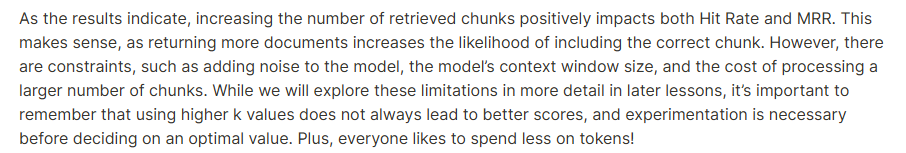

### Evaluation using Relevance and Faithfulness metrics.

Here, we evaluate the answer generated by the LLM. Is the answer using the correct context? Is the answer faithful to the context? Is the answer relevant to the question?

An LLM will answer these questions, more specifically `gpt-5`.

**`FaithfulnessEvaluator`**
Evaluates if the answer is faithful to the retrieved contexts (in other words, whether there's an hallucination).

**`RelevancyEvaluator`**
Evaluates whether the retrieved context and answer are relevant to the user question.

Now, let's see how the top_k value affects these two metrics.


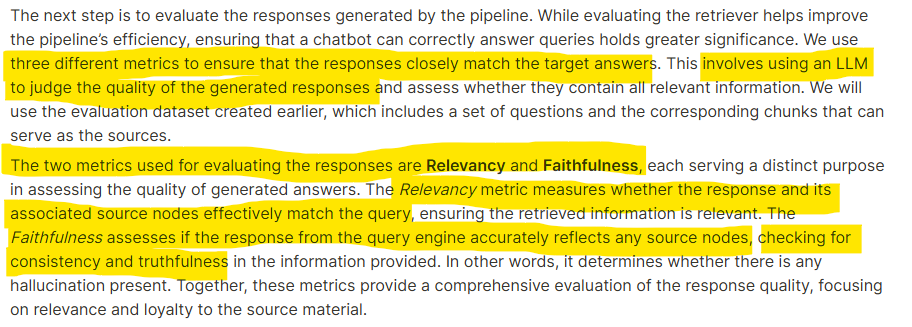
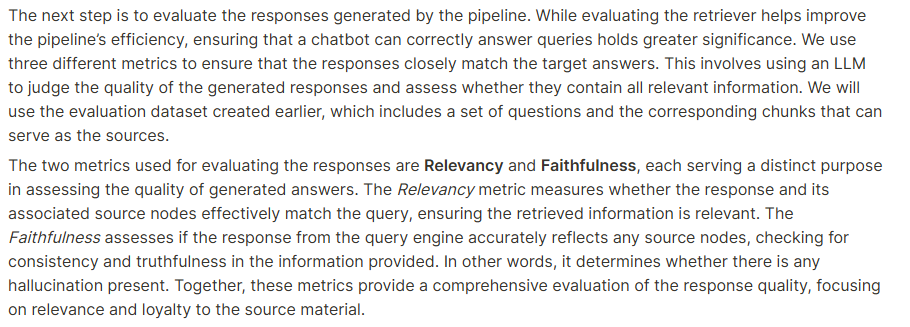

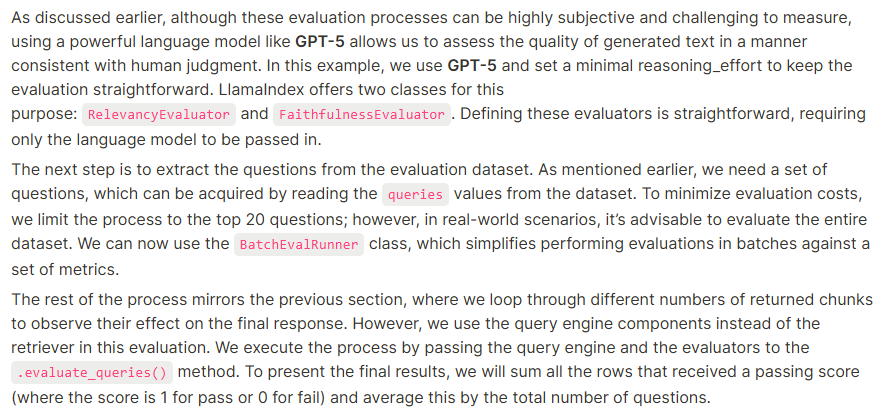

In [53]:
from llama_index.core.evaluation import RelevancyEvaluator, FaithfulnessEvaluator, BatchEvalRunner

# Create your index
from llama_index.core import VectorStoreIndex
index = VectorStoreIndex.from_vector_store(vector_store)

In [54]:
from llama_index.llms.openai import OpenAI

# Define an LLM as a judge
llm_gpt5 = OpenAI(model="gpt-5", additional_kwargs={'reasoning_effort':'minimal'})
llm_gpt5_mini = OpenAI(model="gpt-5-mini", additional_kwargs={'reasoning_effort':'minimal'})

In [55]:

# Initiate the faithfulnes and relevancy evaluator objects
faithfulness_evaluator = FaithfulnessEvaluator(llm=llm_gpt5)
relevancy_evaluator = RelevancyEvaluator(llm=llm_gpt5)

ValueError: Unknown model 'gpt-5'. Please provide a valid OpenAI model name in: gpt-4, gpt-4-32k, gpt-4-1106-preview, gpt-4-0125-preview, gpt-4-turbo-preview, gpt-4-vision-preview, gpt-4-1106-vision-preview, gpt-4-turbo-2024-04-09, gpt-4-turbo, gpt-4o, gpt-4o-2024-05-13, gpt-4o-mini, gpt-4o-mini-2024-07-18, gpt-4-0613, gpt-4-32k-0613, gpt-4-0314, gpt-4-32k-0314, gpt-3.5-turbo, gpt-3.5-turbo-16k, gpt-3.5-turbo-0125, gpt-3.5-turbo-1106, gpt-3.5-turbo-0613, gpt-3.5-turbo-16k-0613, gpt-3.5-turbo-0301, text-davinci-003, text-davinci-002, gpt-3.5-turbo-instruct, text-ada-001, text-babbage-001, text-curie-001, ada, babbage, curie, davinci, gpt-35-turbo-16k, gpt-35-turbo, gpt-35-turbo-0125, gpt-35-turbo-1106, gpt-35-turbo-0613, gpt-35-turbo-16k-0613

In [ ]:

# Extract the questions from the dataset
queries = list(rag_eval_dataset.queries.values())
# Limit to first 10 question to save time (!!remove this line in production!!)
batch_eval_queries = queries[:20]

# The batch evaluator runs the evaluation in batches
runner = BatchEvalRunner(
    {"faithfulness": faithfulness_evaluator, "relevancy": relevancy_evaluator},
    workers=32,
)


# Define a for-loop to try different `similarity_top_k` values
for i in [2, 4, 6, 8, 10]:
    # Set query engine with different number of returned chunks
    query_engine = index.as_query_engine(similarity_top_k=i, llm = llm_gpt5_mini)

    # Run the evaluation
    eval_results = await runner.aevaluate_queries(query_engine, queries=batch_eval_queries)

    # Printing the results
    faithfulness_score = sum(
        result.passing for result in eval_results["faithfulness"]
    ) / len(eval_results["faithfulness"])
    print(f"top_{i} faithfulness_score: {faithfulness_score}")

    relevancy_score = sum(result.passing for result in eval_results["relevancy"]) / len(
        eval_results["relevancy"]
    )
    print(f"top_{i} relevancy_score: {relevancy_score}")
    print("="*15)


### Correctness


In [ ]:
from llama_index.core.evaluation import CorrectnessEvaluator

query = (
    "Can you explain the theory of relativity proposed by Albert Einstein in" " detail?"
)

reference = """
Certainly! Albert Einstein's theory of relativity consists of two main components: special relativity and general relativity. Special relativity, published in 1905, introduced the concept that the laws of physics are the same for all non-accelerating observers and that the speed of light in a vacuum is a constant, regardless of the motion of the source or observer. It also gave rise to the famous equation E=mc², which relates energy (E) and mass (m).

General relativity, published in 1915, extended these ideas to include the effects of gravity. According to general relativity, gravity is not a force between masses, as described by Newton's theory of gravity, but rather the result of the warping of space and time by mass and energy. Massive objects, such as planets and stars, cause a curvature in spacetime, and smaller objects follow curved paths in response to this curvature. This concept is often illustrated using the analogy of a heavy ball placed on a rubber sheet, causing it to create a depression that other objects (representing smaller masses) naturally move towards.

In essence, general relativity provided a new understanding of gravity, explaining phenomena like the bending of light by gravity (gravitational lensing) and the precession of the orbit of Mercury. It has been confirmed through numerous experiments and observations and has become a fundamental theory in modern physics.
"""

response = """
Certainly! Albert Einstein's theory of relativity consists of two main components: special relativity and general relativity. Special relativity, published in 1905, introduced the concept that the laws of physics are the same for all non-accelerating observers and that the speed of light in a vacuum is a constant, regardless of the motion of the source or observer. It also gave rise to the famous equation E=mc², which relates energy (E) and mass (m).

However, general relativity, published in 1915, extended these ideas to include the effects of magnetism. According to general relativity, gravity is not a force between masses but rather the result of the warping of space and time by magnetic fields generated by massive objects. Massive objects, such as planets and stars, create magnetic fields that cause a curvature in spacetime, and smaller objects follow curved paths in response to this magnetic curvature. This concept is often illustrated using the analogy of a heavy ball placed on a rubber sheet with magnets underneath, causing it to create a depression that other objects (representing smaller masses) naturally move towards due to magnetic attraction.
"""

In [ ]:
evaluator = CorrectnessEvaluator(llm=llm_gpt5)

result = evaluator.evaluate(query=query,response=response,reference=reference,)

In [ ]:
result.score

1.5

In [ ]:
result.feedback

'The answer starts correctly about special relativity but then makes a major, fundamental error: it claims general relativity involves magnetism and that magnetic fields from massive objects warp spacetime. GR attributes gravity to spacetime curvature caused by mass-energy (not specifically magnetic fields). The rubber-sheet with magnets analogy is incorrect. This makes the explanation misleading despite partial relevance.'